## Analysis of User-Proxy Evaluation Results

In [1]:
import sys
import os

sys.path.append("../")
os.chdir("../")

In [2]:
import yaml
from mirrorbench.io.paths import Paths

In [6]:
CONFIG_DIRPATH = 'configs'
UNIVERSAL_JUDGE_SUBSTR = 'claude-4-sonnet-judge'  # 'claude-4-sonnet-judge'
UNIVERSAL_ASSISTANT_SUBSTR = 'gpt-4o-assistant'  # 'claude-4-sonnet-v1'
DATASETS = [
    'chatbot_arena_mirror',
    'clariq_mirror',
    'oasst1_mirror',
    'qulac_mirror'
]

paths = Paths.default()

We walk through all yaml files present in `CONFIG_DIRPATH` and collect the run names. Based on these run names, we load the evaluation results that include `UNIVERSAL_JUDGE_SUBSTR`.

In [7]:
run_names = []
dataset_to_run_names = {dataset: [] for dataset in DATASETS}

for dirpath, _, filenames in os.walk(CONFIG_DIRPATH):
    for filename in filenames:
        if not filename.endswith('.yaml'):
            continue
        with open(os.path.join(dirpath, filename), 'r') as f:
            run_config = yaml.safe_load(f)
        name = run_config['run']['name']
        if UNIVERSAL_JUDGE_SUBSTR in name and UNIVERSAL_ASSISTANT_SUBSTR in name and "5seed" not in name:
            run_names.append(name)

print(f"Found {len(run_names)} runs with universal judge:")

for dataset in DATASETS:
    for run_name in run_names:
        if dataset in run_name:
            dataset_to_run_names[dataset].append(run_name)

for dataset, names in dataset_to_run_names.items():
    print(f"{dataset}: {len(names)} runs")
    for name in names:
        print(f"  - {name}")

Found 20 runs with universal judge:
chatbot_arena_mirror: 5 runs
  - chatbot_arena_mirror-claude-4-sonnet-user-gpt-4o-assistant-claude-4-sonnet-judge
  - chatbot_arena_mirror-gemini-2.5-pro-user-gpt-4o-assistant-claude-4-sonnet-judge
  - chatbot_arena_mirror-gpt-4o-user-gpt-4o-assistant-claude-4-sonnet-judge
  - chatbot_arena_mirror-gpt-5-user-gpt-4o-assistant-claude-4-sonnet-judge
  - chatbot_arena_mirror-gpt-oss-120b-user-gpt-4o-assistant-claude-4-sonnet-judge
clariq_mirror: 5 runs
  - clariq_mirror-claude-4-sonnet-user-gpt-4o-assistant-claude-4-sonnet-judge
  - clariq_mirror-gemini-2.5-pro-user-gpt-4o-assistant-claude-4-sonnet-judge
  - clariq_mirror-gpt-4o-user-gpt-4o-assistant-claude-4-sonnet-judge
  - clariq_mirror-gpt-5-user-gpt-4o-assistant-claude-4-sonnet-judge
  - clariq_mirror-gpt-oss-120b-user-gpt-4o-assistant-claude-4-sonnet-judge
oasst1_mirror: 5 runs
  - oasst1_mirror-claude-4-sonnet-user-gpt-4o-assistant-claude-4-sonnet-judge
  - oasst1_mirror-gemini-2.5-pro-user-gpt-4o

In [8]:
dataset_to_results = {dataset: [] for dataset in DATASETS}

for dataset, run_names in dataset_to_run_names.items():
    for run_name in run_names:
        # if "qulac_mirror-gemini-2.5-pro-user" in run_name:
        #     continue
        results = paths.load_run_summary(run_name)
        assert "aggregates" in results, f"Aggregates missing in {run_name}"
        dataset_to_results[dataset].append(results)

print("Loaded evaluation results for all datasets.")
for dataset, results_list in dataset_to_results.items():
    print(f"{dataset}: {len(results_list)} results loaded")

Loaded evaluation results for all datasets.
chatbot_arena_mirror: 5 results loaded
clariq_mirror: 5 results loaded
oasst1_mirror: 5 results loaded
qulac_mirror: 5 results loaded


In [9]:
# Import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches

print("Plotting libraries imported successfully.")

Plotting libraries imported successfully.


---

# Publication-Quality Plots for Paper

This section creates professional, space-efficient plots for the paper.

**Key Updates Based on Feedback:**
1. ✅ Only 3 judge metrics: GTEval, PI-Pairwise, RNR
2. ✅ Diversity metrics included: MATTR, HDD, Yule's K
3. ✅ Compact 3-subplot-per-row layout
4. ✅ Combined figure fits in ~half page

**Main Output:** `fig_combined` - 2×3 grid showing all 6 metrics

---

In [10]:
def set_publication_style():
    """Set publication-quality plot styling."""
    plt.style.use('seaborn-v0_8-paper')
    plt.rcParams.update({
        'font.size': 11,
        'font.family': 'sans-serif',
        'axes.labelsize': 12,
        'axes.titlesize': 13,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
        'figure.dpi': 100,  # Screen preview
        'savefig.dpi': 300,  # High-res save
        'savefig.bbox': 'tight',
        'pdf.fonttype': 42,  # TrueType fonts for editability
        'ps.fonttype': 42,
        'axes.spines.top': False,
        'axes.spines.right': False,
    })

set_publication_style()
print("Publication style set.")

Publication style set.


In [11]:
from matplotlib.colors import LinearSegmentedColormap

# Create custom colormap for "0 is best" metrics
# Green at center (0), red/orange at both extremes
def create_zero_centered_colormap():
    """
    Create a colormap where:
    - Center (0) = Green (best)
    - Extremes (both + and -) = Red/Orange (worst)
    
    This is different from standard diverging colormaps which go:
    Red (negative) → White/Yellow (0) → Green (positive)
    
    Instead, this goes:
    Red (very negative) → Green (0) → Red (very positive)
    """
    # Define colors: red → orange → yellow → green → yellow → orange → red
    colors = [
        '#d73027',  # Red (far negative)
        '#fc8d59',  # Orange
        '#fee090',  # Yellow
        '#91cf60',  # Light green
        '#1a9850',  # Green (at 0 - best!)
        '#91cf60',  # Light green  
        '#fee090',  # Yellow
        '#fc8d59',  # Orange
        '#d73027',  # Red (far positive)
    ]
    
    n_bins = 256
    cmap = LinearSegmentedColormap.from_list('zero_centered', colors, N=n_bins)
    return cmap

# Create the colormap
ZERO_CENTERED_CMAP = create_zero_centered_colormap()
print("✓ Created custom zero-centered colormap (green=0, red=extremes)")

✓ Created custom zero-centered colormap (green=0, red=extremes)


In [12]:
def extract_model_name(run_name, dataset_name):
    """Extract user proxy model name from run name."""
    # Remove dataset prefix and judge suffix
    # e.g., "chatbot_arena_mirror-gpt-4o-user-gpt-4o-assistant-gpt-4o-judge" -> "gpt-4o"
    prefix = f"{dataset_name}-"
    if run_name.startswith(prefix):
        remainder = run_name[len(prefix):]
        # Extract until "-user"
        if "-user-" in remainder:
            return remainder.split("-user-")[0]
    return run_name

def get_metric_value(agg, metric_name):
    """
    Extract the appropriate metric value based on metric type.
    
    Rules:
    1. For PI-Pairwise: Return (mean - 0.5) as signed value
    2. For all other metrics: Use raw mean
    """
    base_mean = agg['mean']
    
    # For PI-Pairwise, compute signed difference from 0.5
    if 'pi_pairwise' in metric_name:
        return base_mean - 0.5
    
    # For all other metrics, use raw mean
    return base_mean

def build_metrics_dataframe(dataset_to_results, metric_names):
    """
    Build a tidy DataFrame for plotting.
    
    Returns DataFrame with columns:
    - dataset: dataset name
    - model: model name
    - metric: metric name
    - mean: metric mean (with PI as signed difference from 0.5)
    - ci: confidence interval
    - std: standard deviation
    """
    rows = []
    
    for dataset, results_list in dataset_to_results.items():
        for result in results_list:
            # Extract model name from run_id
            run_id = result['run']['run_id']
            model = extract_model_name(run_id, dataset)
            
            # Extract metrics
            for agg in result['aggregates']:
                metric_name = agg['metric_name']
                if metric_name in metric_names:
                    rows.append({
                        'dataset': dataset,
                        'model': model,
                        'metric': metric_name,
                        'mean': get_metric_value(agg, metric_name),
                        'ci': agg['confidence_interval'],
                        'std': agg['standard_deviation'],
                        'sample_size': agg['sample_size']
                    })
    
    return pd.DataFrame(rows)

## Configuration: Metrics to Include in Paper

In [13]:
# Modular metric configuration
JUDGE_METRICS = [
    'metric:judge/gteval',
    'metric:judge/pi_pairwise', 
    'metric:judge/rubric_and_reason',
]

DIVERSITY_METRICS = [
    'metric:lexical/mattr',
    'metric:lexical/hdd',
    'metric:lexical/yules_k'
]

ALL_PAPER_METRICS = JUDGE_METRICS + DIVERSITY_METRICS

# Metric labels for plots
# Note: No arrows for metrics where 0 is best (PI-Pairwise, diversity metrics)
METRIC_LABELS = {
    'metric:judge/gteval': 'GTEval ↑',
    'metric:judge/pi_pairwise': 'PI-Deviation ($\Delta w$)',  # 0 is best
    'metric:judge/rubric_and_reason': 'RNR ↑',
    'metric:lexical/mattr': 'MATTR',  # 0 is best (z-score)
    'metric:lexical/hdd': 'HDD',  # 0 is best (z-score)
    'metric:lexical/yules_k': "Yule's K"  # 0 is best (z-score)
}

# Colorbar labels (what the score represents)
COLORBAR_LABELS = {
    'metric:judge/gteval': 'Score',
    'metric:judge/pi_pairwise': 'Deviation from 0.5',
    'metric:judge/rubric_and_reason': 'Score',
    'metric:lexical/mattr': 'Z-Score\n(Deviation)',
    'metric:lexical/hdd': 'Z-Score\n(Deviation)',
    'metric:lexical/yules_k': 'Z-Score\n(Deviation)'
}

print(f"Judge metrics (n={len(JUDGE_METRICS)}): {[METRIC_LABELS[m] for m in JUDGE_METRICS]}")
print(f"Diversity metrics (n={len(DIVERSITY_METRICS)}): {[METRIC_LABELS[m] for m in DIVERSITY_METRICS]}")
print(f"Total metrics for paper: {len(ALL_PAPER_METRICS)}")
print(f"\nMetric scoring:")
print(f"  GTEval: raw mean (↑ higher is better)")
print(f"  PI-Pairwise: mean - 0.5 (0 is best - indistinguishable)")
print(f"  RNR: raw mean (↑ higher is better)")
print(f"  Diversity (MATTR, HDD, Yule's K): z-scores (0 is best - matches human)")

Judge metrics (n=3): ['GTEval ↑', 'PI-Deviation ($\\Delta w$)', 'RNR ↑']
Diversity metrics (n=3): ['MATTR', 'HDD', "Yule's K"]
Total metrics for paper: 6

Metric scoring:
  GTEval: raw mean (↑ higher is better)
  PI-Pairwise: mean - 0.5 (0 is best - indistinguishable)
  RNR: raw mean (↑ higher is better)
  Diversity (MATTR, HDD, Yule's K): z-scores (0 is best - matches human)


<>:20: SyntaxWarning: invalid escape sequence '\D'
<>:20: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_1482/977248885.py:20: SyntaxWarning: invalid escape sequence '\D'
  'metric:judge/pi_pairwise': 'PI-Deviation ($\Delta w$)',  # 0 is best


In [14]:
# Build DataFrames for both metric types
df_judge = build_metrics_dataframe(dataset_to_results, JUDGE_METRICS)
df_diversity = build_metrics_dataframe(dataset_to_results, DIVERSITY_METRICS)
df_all = build_metrics_dataframe(dataset_to_results, ALL_PAPER_METRICS)

print(f"Judge metrics DataFrame: {len(df_judge)} rows")
print(f"Diversity metrics DataFrame: {len(df_diversity)} rows")
print(f"All metrics DataFrame: {len(df_all)} rows")
print(f"\nModels: {sorted(df_all['model'].unique())}")
print(f"Datasets: {sorted(df_all['dataset'].unique())}")

# IMPORTANT: Compute a GLOBAL model ordering based on ALL metrics
# This ensures both judge and diversity figures use the same ordering
print("\n" + "="*60)
print("Computing global model ordering for consistent comparison...")
print("="*60)

GLOBAL_MODEL_ORDER = df_judge.groupby('model')['mean'].apply(
    lambda x: x.abs().mean()  # Average absolute value across ALL metrics
).sort_values(ascending=True).index.tolist()

print(f"\nGlobal model order (best to worst, averaged across all metrics):")
for i, model in enumerate(GLOBAL_MODEL_ORDER, 1):
    avg_abs = df_all[df_all['model'] == model]['mean'].abs().mean()
    print(f"  {i}. {model:30s} (avg |score|: {avg_abs:.3f})")
    
print(f"\nThis ordering will be used for BOTH judge and diversity figures.")

Judge metrics DataFrame: 60 rows
Diversity metrics DataFrame: 60 rows
All metrics DataFrame: 120 rows

Models: ['claude-4-sonnet', 'gemini-2.5-pro', 'gpt-4o', 'gpt-5', 'gpt-oss-120b']
Datasets: ['chatbot_arena_mirror', 'clariq_mirror', 'oasst1_mirror', 'qulac_mirror']

Computing global model ordering for consistent comparison...

Global model order (best to worst, averaged across all metrics):
  1. gpt-5                          (avg |score|: 0.619)
  2. gpt-oss-120b                   (avg |score|: 0.487)
  3. gpt-4o                         (avg |score|: 0.388)
  4. claude-4-sonnet                (avg |score|: 0.623)
  5. gemini-2.5-pro                 (avg |score|: 0.459)

This ordering will be used for BOTH judge and diversity figures.


## Final Plots for Paper

Two figures with 3 subplots each (one row per metric type).

Creating judge metrics heatmap...


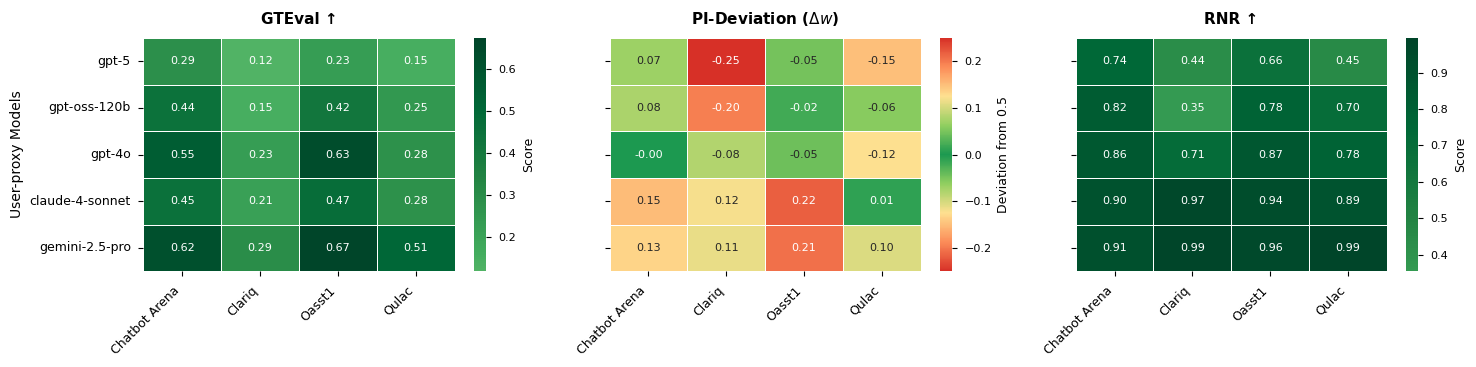

In [15]:
def plot_paper_heatmaps(df, metrics_list, metric_labels, colorbar_labels, 
                         title="Performance Heatmap", figsize=(15, 3.8),
                         model_order=None):
    """
    Create publication-ready heatmap with 3 subplots in a single row.
    
    Key fix: All subplots use the SAME model ordering for consistency.
    If model_order is provided, uses that. Otherwise, computes order from data.
    
    Styling rules:
    - Only title is bold
    - Y-axis label: "User-proxy Models" (not bold)
    - Colorbar shows metric-specific score name
    - Clean, professional appearance
    """
    n_metrics = len(metrics_list)
    
    # Create figure with horizontal layout
    fig, axes = plt.subplots(1, n_metrics, figsize=figsize)
    if n_metrics == 1:
        axes = [axes]
    
    # Determine model order
    if model_order is None:
        # Compute from data: average absolute deviation from 0
        model_scores = df.groupby('model')['mean'].apply(
            lambda x: x.abs().mean()
        ).sort_values(ascending=True)
        CONSISTENT_MODEL_ORDER = model_scores.index.tolist()
    else:
        # Use provided global order
        CONSISTENT_MODEL_ORDER = model_order
    
    # Metrics where 0 is best (closer to 0 = better)
    ZERO_IS_BEST = ['pi_pairwise', 'mattr', 'hdd', 'yules_k']
    
    for idx, metric in enumerate(metrics_list):
        ax = axes[idx]
        df_metric = df[df['metric'] == metric]
        
        # Create pivot table: rows=models, columns=datasets
        pivot = df_metric.pivot_table(
            values='mean', 
            index='model', 
            columns='dataset',
            aggfunc='first'
        )
        
        # Use consistent model order across all subplots
        pivot = pivot.reindex(CONSISTENT_MODEL_ORDER)
        
        # Determine if this is a "0 is best" metric
        is_zero_best = any(keyword in metric for keyword in ZERO_IS_BEST)
        
        # Determine vmin/vmax and colormap
        vmin, vmax = pivot.min().min(), pivot.max().max()
        
        if is_zero_best:
            # For "0 is best": use custom colormap where green=0, red=extremes
            abs_max = max(abs(vmin), abs(vmax))
            vmin, vmax = -abs_max, abs_max
            cmap = ZERO_CENTERED_CMAP  # Custom colormap: red → green (at 0) → red
            center = 0
        else:
            # For "higher is better" metrics
            if vmin < 0 and vmax > 0:
                # Data spans negative and positive: use diverging centered at 0
                abs_max = max(abs(vmin), abs(vmax))
                vmin, vmax = -abs_max, abs_max
                cmap = 'RdYlGn'
                center = 0
            else:
                # Data is all positive or all negative: use sequential
                cmap = 'YlGn' if vmin >= 0 else 'RdYlGn'
                center = 0
        
        # Get colorbar label
        cbar_label = colorbar_labels.get(metric, 'Score')
        
        # Create heatmap
        sns.heatmap(pivot, ax=ax, 
                   cmap=cmap, center=center,
                   annot=True, fmt='.2f',
                   cbar_kws={'label': cbar_label},
                   linewidths=0.5, linecolor='white',
                   vmin=vmin, vmax=vmax,
                   annot_kws={'fontsize': 8})
        
        # Formatting - NO BOLD except title
        ax.set_title(metric_labels.get(metric, metric.split('/')[-1]), 
                    fontweight='bold', pad=10, fontsize=11)
        ax.set_xlabel('')
        ax.set_ylabel('User-proxy Models' if idx == 0 else '', fontsize=10)
        
        # Clean up labels
        ax.set_xticklabels([col.replace('_mirror', '').replace('_', ' ').title() 
                           for col in pivot.columns], rotation=45, ha='right', fontsize=9)
        if idx == 0:
            ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=9)
        else:
            ax.set_yticklabels([])  # Remove y-labels for non-first plots
        
        # Style the colorbar label (not bold)
        cbar = ax.collections[0].colorbar
        cbar.ax.yaxis.label.set_fontsize(9)
        cbar.ax.yaxis.label.set_fontweight('normal')
        cbar.ax.tick_params(labelsize=8)
    
    # plt.suptitle(title, fontsize=13, fontweight='bold', y=1.00)
    plt.tight_layout()
    return fig

# Create judge metrics figure with global model order
print("Creating judge metrics heatmap...")
fig_judge = plot_paper_heatmaps(
    df_judge, JUDGE_METRICS, METRIC_LABELS, COLORBAR_LABELS,
    title="Judge Metrics: Human-Likeness Performance",
    model_order=GLOBAL_MODEL_ORDER  # Use global order
)
plt.show()

Creating diversity metrics heatmap...


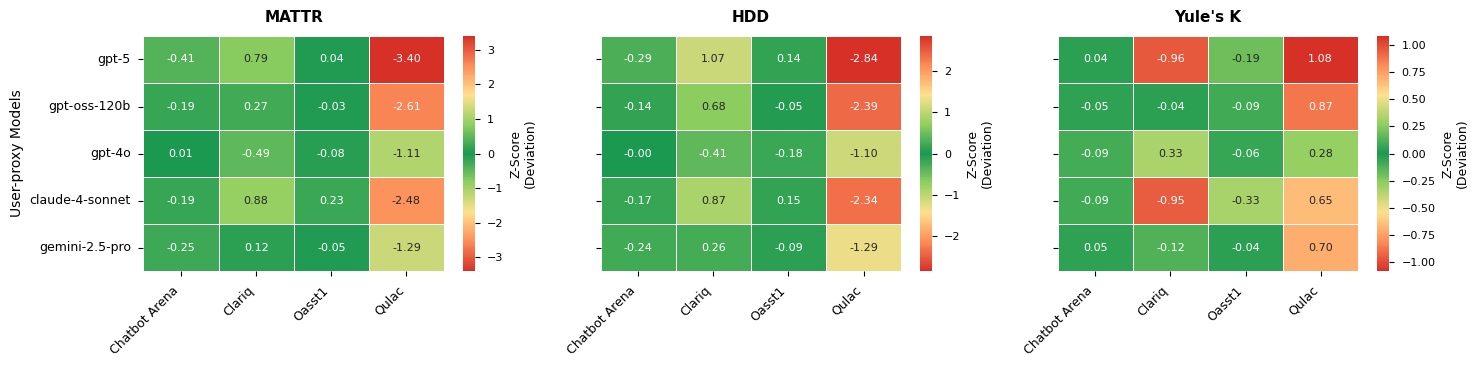

In [16]:
# Create diversity metrics figure with the SAME global model order
print("Creating diversity metrics heatmap...")
fig_diversity = plot_paper_heatmaps(
    df_diversity, DIVERSITY_METRICS, METRIC_LABELS, COLORBAR_LABELS,
    title="Diversity Metrics: Lexical Quality Performance",
    model_order=GLOBAL_MODEL_ORDER  # Use same global order
)
plt.show()

## Summary

### Final Figures for Paper:

**Figure 1: Judge Metrics** (`fig_judge`)
- **GTEval ↑**: Raw mean score (higher is better)
- **PI-Pairwise**: Shows (mean - 0.5) as signed deviation (0 is best)
- **RNR ↑**: Raw mean score (higher is better)

**Figure 2: Diversity Metrics** (`fig_diversity`)
- **MATTR, HDD, Yule's K**: Z-scores (0 is best - matches human)

**Figure 3: Token Consumption** (`fig_tokens`)
- Stacked bar chart showing input/output tokens per episode
- Normalized per episode for fair comparison across datasets
- Uses same model ordering as other figures for consistency
- Compact design fits in single column (~3.5 inches tall)

### Key Features:

**✅ Fixed Model Ordering:**
- **ALL figures** use the **SAME model order**
- Models are sorted by average absolute score across ALL 6 metrics
- Order: Best performers (closest to 0 overall) → Worst performers
- **You can now easily compare across:**
  - Subplots within a figure (left to right)
  - Between all figures (judge vs diversity vs tokens)

**Colormap Logic:**
- **Custom "Zero-Centered" Colormap** for PI-Pairwise and diversity:
  - Red (far from 0) → Yellow → **Green (at 0 - BEST!)** → Yellow → Red (far from 0)
  - Non-linear: both +2.0 and -2.0 show as red (bad)
  
- **Standard Diverging/Sequential** for GTEval and RNR:
  - Green = good (high values), Red = bad (low values)

**Styling:**
- ✅ Only titles are bold
- ✅ Y-axis: "User-proxy Models" (not bold)
- ✅ Model names shown only on leftmost subplot (for heatmaps)
- ✅ All subplots aligned with consistent row order
- ✅ Arrows (↑) only for "higher is better" metrics
- ✅ 3 subplots per row (space-efficient)

### Space Estimate:
- Judge metrics figure: ~3.8 inches tall
- Diversity metrics figure: ~3.8 inches tall
- Token consumption figure: ~3.5 inches tall (single subplot)
- Total for all three: ~11 inches (~0.7 page in 2-column format)

### Token Consumption Insights:
- Shows actual resource usage for each user proxy model
- Input tokens: Context provided to the model
- Output tokens: Generated responses
- Helps evaluate computational efficiency vs. performance tradeoffs

## Save Figures for Publication

## Token Consumption Analysis

Extract and visualize token input/output consumption across user proxy models.

In [17]:
def extract_token_consumption(dataset_to_results):
    """
    Extract token consumption data from run results.
    
    Returns DataFrame with columns:
    - dataset: dataset name
    - model: model name
    - tokens_input: total input tokens
    - tokens_output: total output tokens
    - tokens_total: sum of input and output
    - episodes: number of successful episodes
    """
    rows = []
    
    for dataset, results_list in dataset_to_results.items():
        for result in results_list:
            # Extract model name from run_id
            run_id = result['run']['run_id']
            model = extract_model_name(run_id, dataset)
            
            # Extract telemetry stats
            telemetry = result.get('telemetry_stats', {})
            tokens_in = telemetry.get('tokens_input', 0.0)
            tokens_out = telemetry.get('tokens_output', 0.0)
            episodes_success = telemetry.get('episodes_successful', 0.0)
            
            # Only include if we have valid data
            if tokens_in > 0 or tokens_out > 0:
                rows.append({
                    'dataset': dataset,
                    'model': model,
                    'tokens_input': tokens_in,
                    'tokens_output': tokens_out,
                    'tokens_total': tokens_in + tokens_out,
                    'episodes': int(episodes_success)
                })
    
    return pd.DataFrame(rows)

# Extract token consumption data
df_tokens = extract_token_consumption(dataset_to_results)

print(f"Token consumption data extracted: {len(df_tokens)} rows")
print(f"\nSample data:")
print(df_tokens.head(10))

# Compute tokens per episode for normalization
df_tokens['tokens_per_episode'] = df_tokens['tokens_total'] / df_tokens['episodes']
df_tokens['input_per_episode'] = df_tokens['tokens_input'] / df_tokens['episodes']
df_tokens['output_per_episode'] = df_tokens['tokens_output'] / df_tokens['episodes']

print(f"\nToken consumption summary:")
print(df_tokens.groupby('model')[['tokens_input', 'tokens_output', 'tokens_total']].sum().sort_values('tokens_total', ascending=False))

Token consumption data extracted: 20 rows

Sample data:
                dataset            model  tokens_input  tokens_output  \
0  chatbot_arena_mirror  claude-4-sonnet     2518852.0       462679.0   
1  chatbot_arena_mirror   gemini-2.5-pro     2072413.0       364679.0   
2  chatbot_arena_mirror           gpt-4o     2340096.0       380504.0   
3  chatbot_arena_mirror            gpt-5     5009736.0      2602269.0   
4  chatbot_arena_mirror     gpt-oss-120b     5894000.0      1147650.0   
5         clariq_mirror  claude-4-sonnet     5632410.0      1011969.0   
6         clariq_mirror   gemini-2.5-pro     4593232.0       691061.0   
7         clariq_mirror           gpt-4o     7318080.0      1127269.0   
8         clariq_mirror            gpt-5     8737739.0      7159084.0   
9         clariq_mirror     gpt-oss-120b     9980775.0      6246548.0   

   tokens_total  episodes  
0     2981531.0      1365  
1     2437092.0      1365  
2     2720600.0      1560  
3     7612005.0      1363  


Creating token consumption plot...


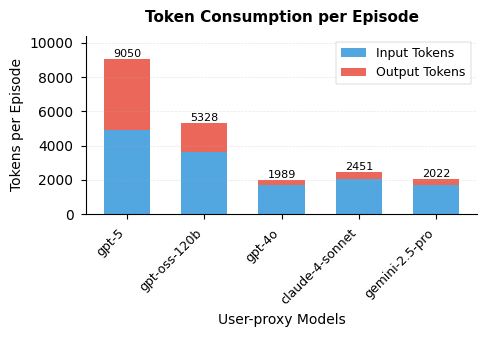

In [18]:
def plot_token_consumption(df_tokens, model_order=None, figsize=(5, 3.5)):
    """
    Create a compact stacked bar chart showing token consumption.
    
    Designed to fit in a single subplot for paper layout.
    Shows input/output tokens stacked per model, averaged across datasets.
    """
    # Aggregate across datasets (average per episode)
    df_agg = df_tokens.groupby('model').agg({
        'input_per_episode': 'mean',
        'output_per_episode': 'mean',
        'tokens_per_episode': 'mean',
        'episodes': 'sum'
    }).reset_index()
    
    # Use provided model order or compute from data
    if model_order is None:
        model_order = df_agg.sort_values('tokens_per_episode', ascending=False)['model'].tolist()
    
    # Reindex to match model order
    df_agg['model'] = pd.Categorical(df_agg['model'], categories=model_order, ordered=True)
    df_agg = df_agg.sort_values('model')
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create stacked bar chart
    x_pos = np.arange(len(df_agg))
    width = 0.6
    
    # Plot stacked bars
    bars1 = ax.bar(x_pos, df_agg['input_per_episode'], width, 
                   label='Input Tokens', color='#3498db', alpha=0.85)
    bars2 = ax.bar(x_pos, df_agg['output_per_episode'], width,
                   bottom=df_agg['input_per_episode'],
                   label='Output Tokens', color='#e74c3c', alpha=0.85)
    
    # Add value labels on bars
    for i, (inp, out) in enumerate(zip(df_agg['input_per_episode'], df_agg['output_per_episode'])):
        total = inp + out
        # Only show total on top
        ax.text(i, total + 5, f'{int(total)}', ha='center', va='bottom', fontsize=8)
    
    # Formatting
    ax.set_ylabel('Tokens per Episode', fontsize=10)
    ax.set_xlabel('User-proxy Models', fontsize=10)
    ax.set_title('Token Consumption per Episode', fontweight='bold', fontsize=11, pad=10)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(df_agg['model'], rotation=45, ha='right', fontsize=9)
    ax.legend(loc='upper right', fontsize=9, frameon=True, fancybox=False, edgecolor='gray')
    ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.5)
    
    # Set y-axis to start from 0
    ax.set_ylim(0, df_agg['tokens_per_episode'].max() * 1.15)
    
    plt.tight_layout()
    return fig

# Create token consumption plot using same model order
print("Creating token consumption plot...")
fig_tokens = plot_token_consumption(df_tokens, model_order=GLOBAL_MODEL_ORDER)
plt.show()

In [19]:
# Create output directory for figures
import os
output_dir = 'figures'
os.makedirs(output_dir, exist_ok=True)

def save_figure(fig, name):
    """Save figure in both PDF and PNG formats."""
    # PDF for vector graphics (best for papers)
    fig.savefig(f"{output_dir}/{name}.pdf", dpi=300, bbox_inches='tight', format='pdf')
    # PNG for quick preview
    fig.savefig(f"{output_dir}/{name}.png", dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {output_dir}/{name}.pdf and .png")

# Show heatmaps but don't save them (keeping for reference only)
print("\nDisplaying heatmap figures (not saving files)...")
print("Note: Heatmaps are shown for reference but not saved.")
print("The comprehensive grid plot contains all metrics in one figure.\n")

# Comment out heatmap saves - we'll only keep them displayed
# save_figure(fig_judge, "user_proxy_judge_metric_results")
# save_figure(fig_diversity, "user_proxy_diversity_metric_results")

# Save only the token consumption figure
print("Saving token consumption figure...")
save_figure(fig_tokens, "user_proxy_token_consumption")

print(f"\n✓ Token consumption figure saved to: {os.path.abspath(output_dir)}")
print(f"  Figure: {output_dir}/user_proxy_token_consumption.pdf")


Displaying heatmap figures (not saving files)...
Note: Heatmaps are shown for reference but not saved.
The comprehensive grid plot contains all metrics in one figure.

Saving token consumption figure...
✓ Saved: figures/user_proxy_token_consumption.pdf and .png

✓ Token consumption figure saved to: /mnt/shared-fs-1/ashutosh/mirrorbench/figures
  Figure: figures/user_proxy_token_consumption.pdf


## Additional Customization Options

You can customize the plots further:

In [20]:
# Additional Customization Examples

# Example 1: Adjust figure size for different venues
# fig_judge = plot_paper_heatmaps(df_judge, JUDGE_METRICS, METRIC_LABELS, 
#                                  COLORBAR_LABELS, figsize=(12, 3.5))  # Narrower

# Example 2: Filter to specific models only
# top_models = ['gpt-4o', 'claude-3.7-sonnet', 'gemini-2.5-pro']
# df_filtered = df_judge[df_judge['model'].isin(top_models)]
# fig = plot_paper_heatmaps(df_filtered, JUDGE_METRICS, METRIC_LABELS, COLORBAR_LABELS)

# Example 3: Export data as LaTeX table
# pivot = df_judge.pivot_table(values='mean', index='model', 
#                               columns=['dataset', 'metric'], aggfunc='first')
# pivot.to_latex('results_judge.tex', float_format='%.3f')

# Example 4: Show only top-5 performing models
# top5 = df_all.groupby('model')['mean'].mean().nlargest(5).index
# df_top5 = df_all[df_all['model'].isin(top5)]

print("Quick reference:")
print("- Figures: fig_judge, fig_diversity")
print("- Function: plot_paper_heatmaps()")
print("- Metrics: JUDGE_METRICS, DIVERSITY_METRICS")
print("- Labels: METRIC_LABELS, COLORBAR_LABELS")

Quick reference:
- Figures: fig_judge, fig_diversity
- Function: plot_paper_heatmaps()
- Metrics: JUDGE_METRICS, DIVERSITY_METRICS
- Labels: METRIC_LABELS, COLORBAR_LABELS


---

# Bar Chart Visualizations (Paper Style)

This section creates bar chart visualizations matching the style shown in the paper:
- Side-by-side metrics in a grid layout
- Consistent color coding for each model across all metrics
- Reference lines for baselines (random/average/zero)
- Better for visual comparison across metrics

---

In [21]:
# Define consistent color palette for models (matching paper style)
MODEL_COLORS = {
    'gpt-4o': '#e8a87c',           # Orange (similar to GPT-4-Turbo in paper)
    'gpt-5': '#f27a5e',            # Red/coral (similar to GPT-4o in paper)
    'gpt-oss-120b': '#85c5ce',     # Light blue (similar to GLM-4 in paper)
    'claude-4-sonnet': '#5b9bd5',  # Blue (similar to Claude-3.5 in paper)
    'gemini-2.5-pro': '#c9c9c9',   # Gray (similar to Qwen2 in paper)
}

# Alternative: Use a colorblind-friendly palette
# from matplotlib.colors import to_rgba
# You can uncomment this to use colorblind-friendly colors
# MODEL_COLORS = {
#     'gpt-4o': '#E69F00',        # Orange
#     'gpt-5': '#D55E00',         # Red-orange  
#     'gpt-oss-120b': '#56B4E9',  # Sky blue
#     'claude-4-sonnet': '#0072B2', # Blue
#     'gemini-2.5-pro': '#999999', # Gray
# }

print("Model color palette defined:")
for model, color in MODEL_COLORS.items():
    print(f"  {model:20s} → {color}")

Model color palette defined:
  gpt-4o               → #e8a87c
  gpt-5                → #f27a5e
  gpt-oss-120b         → #85c5ce
  claude-4-sonnet      → #5b9bd5
  gemini-2.5-pro       → #c9c9c9


## Generate Bar Chart Visualizations

Create all metrics in a single combined figure (2 rows × 3 columns).

## Save Bar Chart Figures

## Comparison: Bar Charts vs Heatmaps

### Bar Chart Style (Paper-Inspired)

**Advantages:**
- ✅ **Direct visual comparison** - Easy to see relative performance across models for each metric
- ✅ **Consistent colors** - Same model = same color across all subplots
- ✅ **Reference lines** - Clear baselines for random/average performance
- ✅ **Error bars** - Shows confidence intervals directly
- ✅ **Better for small datasets** - Works well with 5-6 models
- ✅ **Publication-ready** - Clean, professional appearance matching academic papers

**Use when:**
- You want to emphasize cross-metric comparison
- You have a limited number of models (≤10)
- You want to show uncertainty (confidence intervals)

### Heatmap Style (Original)

**Advantages:**
- ✅ **Compact representation** - Shows models × datasets in a grid
- ✅ **Color-coded values** - Quick visual identification of high/low values
- ✅ **Better for large datasets** - Scales well with many models/datasets
- ✅ **Exact values visible** - Annotated with numeric values

**Use when:**
- You have many models (>10) or multiple datasets to compare
- Space is limited
- Exact numeric values are important

### Recommendation

For your paper with 5-6 models:
- **Use bar charts** for main results (matches paper style, easier to read)
- **Use heatmaps** for supplementary material or when showing dataset-specific breakdowns

Both visualizations are saved and available for your use!

---

# Comprehensive Dataset × Metric Grid

Create a single figure showing all 4 datasets × 6 metrics with:
- 4 rows (one per dataset)
- 6 columns (one per metric)
- Calibrated mean as reference line
- Compact layout with legible, non-bold titles

---

In [22]:
def get_calibrated_mean_reference(dataset_name, metric_name, dataset_to_results):
    """
    Extract calibrated mean (human reference) for a dataset-metric combination.

    This looks for reference statistics in the aggregates extras:
    - For judge metrics with calibration: uses extras.calibration.hh_mean
    - For rubric metrics: uses extras.reference_mean  
    - For lexical metrics: uses extras.mean_human_raw

    Returns None if not available.
    """
    # Look through results to find reference stats for this dataset-metric combo
    if dataset_to_results is None:
        return None

    results_list = dataset_to_results.get(dataset_name, [])

    for result in results_list:
        # Check aggregates for this specific metric
        for agg in result.get('aggregates', []):
            if agg['metric_name'] == metric_name:
                extras = agg.get('extras', {})

                # Try different reference fields based on metric type
                # 1. Judge metrics with calibration (GTEval, PI-Pairwise)
                calibration = extras.get('calibration', {})
                if 'hh_mean' in calibration:
                    hh_mean = calibration['hh_mean']
                    print(f"  [{metric_name}] Using hh_mean = {hh_mean:.3f}")
                    if 'pi_pairwise' in metric_name:
                        # For PI-Pairwise, return signed difference from 0.5
                        signed_hh_mean = hh_mean - 0.5
                        print(f"  [{metric_name}] Adjusted hh_mean for PI-Pairwise = {signed_hh_mean:.3f}")
                        return signed_hh_mean
                    return hh_mean

                # 2. Rubric-based judge metrics
                if 'reference_mean' in extras:
                    ref_mean = extras['reference_mean']
                    print(f"  [{metric_name}] Using reference_mean = {ref_mean:.3f}")
                    return ref_mean

                # # 3. Lexical metrics
                # if 'mean_human_raw' in extras:
                #     human_raw = extras['mean_human_raw']
                #     print(f"  [{metric_name}] Using mean_human_raw = {human_raw:.3f}")
                #     return human_raw

    # Fallback: For zero-best metrics, use 0.0; otherwise None
    ZERO_IS_BEST = ['pi_pairwise', 'mattr', 'hdd', 'yules_k']
    is_zero_best = any(keyword in metric_name for keyword in ZERO_IS_BEST)

    if is_zero_best:
        print(f"  [{metric_name}] Using zero reference (z-score metric)")
        return 0.0

    print(f"  [{metric_name}] No reference mean found")
    return None


def get_calibrated_mean_pp(dataset_name, metric_name, dataset_to_results):
    if dataset_to_results is None:
        return None

    results_list = dataset_to_results.get(dataset_name, [])

    for result in results_list:
        # Check aggregates for this specific metric
        for agg in result.get('aggregates', []):
            if agg['metric_name'] == metric_name:
                extras = agg.get('extras', {})

                # Try different reference fields based on metric type
                # 1. Judge metrics with calibration (GTEval, PI-Pairwise)
                calibration = extras.get('calibration', {})
                if 'pp_mean' in calibration:
                    hh_mean = calibration['pp_mean']
                    print(f"  [{metric_name}] Using pp_mean = {hh_mean:.3f}")
                    if 'pi_pairwise' in metric_name:
                        # For PI-Pairwise, return signed difference from 0.5
                        signed_hh_mean = hh_mean - 0.5
                        print(f"  [{metric_name}] Adjusted hh_mean for PI-Pairwise = {signed_hh_mean:.3f}")
                        return signed_hh_mean
                    return hh_mean

                # # 2. Rubric-based judge metrics
                # if 'reference_mean' in extras:
                #     ref_mean = extras['reference_mean']
                #     print(f"  [{metric_name}] Using reference_mean = {ref_mean:.3f}")
                #     return ref_mean

                # # 3. Lexical metrics
                # if 'mean_human_raw' in extras:
                #     human_raw = extras['mean_human_raw']
                #     print(f"  [{metric_name}] Using mean_human_raw = {human_raw:.3f}")
                #     return human_raw

    # # Fallback: For zero-best metrics, use 0.0; otherwise None
    # ZERO_IS_BEST = ['pi_pairwise', 'mattr', 'hdd', 'yules_k']
    # is_zero_best = any(keyword in metric_name for keyword in ZERO_IS_BEST)

    # if is_zero_best:
    #     print(f"  [{metric_name}] Using zero reference (z-score metric)")
    #     return 0.0

    # print(f"  [{metric_name}] No reference mean found")
    return None

In [23]:
# Check which datasets we have data for
available_datasets = sorted(df_all['dataset'].unique())
print(f"Available datasets with data: {available_datasets}")
print(f"Number of datasets: {len(available_datasets)}")

# We'll use only the datasets that have data
DATASETS_FOR_GRID = available_datasets

Available datasets with data: ['chatbot_arena_mirror', 'clariq_mirror', 'oasst1_mirror', 'qulac_mirror']
Number of datasets: 4


In [24]:
# # Save the comprehensive grid figure
# print("Saving comprehensive grid figure...")
# save_figure(fig_comprehensive_grid, "user_proxy_comprehensive_dataset_metric_grid")

# print(f"\n✓ Comprehensive grid saved to: {os.path.abspath(output_dir)}")
# print(f"\nComprehensive figure:")
# print(f"  {output_dir}/user_proxy_comprehensive_dataset_metric_grid.pdf")
# print(f"  {output_dir}/user_proxy_comprehensive_dataset_metric_grid.png")
# print(f"\nThis single figure shows:")
# print(f"  - All {len(DATASETS_FOR_GRID)} datasets (rows)")
# print(f"  - All {len(ALL_PAPER_METRICS)} metrics (columns)")
# print(f"  - Calibrated mean reference lines")
# print(f"  - Legible non-bold titles")

In [25]:
def plot_dataset_metric_grid(df, datasets, metrics_list, metric_labels,
                              dataset_to_results=None,
                              figsize=(18, 12),
                              model_order=None, model_colors=None,
                              show_ci=True):
    """
    Create a comprehensive grid: datasets (rows) × metrics (columns).

    Now displays reference means (hh_mean, reference_mean, or mean_human_raw) from run results.

    Parameters:
    -----------
    df : DataFrame
        Tidy dataframe with columns: model, metric, mean, ci, dataset
    datasets : list
        List of dataset names to plot (one per row)
    metrics_list : list
        List of metric names to plot (one per column)
    metric_labels : dict
        Mapping from metric name to display label
    dataset_to_results : dict
        Original results for extracting reference means (hh_mean, reference_mean, etc.)
    figsize : tuple
        Figure size (width, height)
    model_order : list
        Order of models
    model_colors : dict
        Color mapping for each model
    show_ci : bool
        Whether to show confidence interval error bars
    """
    import numpy as np
    import pandas as pd

    n_datasets = len(datasets)
    n_metrics = len(metrics_list)

    # Create figure with grid layout
    fig, axes = plt.subplots(n_datasets, n_metrics, figsize=figsize)

    # Ensure axes is 2D
    if n_datasets == 1 and n_metrics == 1:
        axes = np.array([[axes]])
    elif n_datasets == 1:
        axes = axes.reshape(1, -1)
    elif n_metrics == 1:
        axes = axes.reshape(-1, 1)

    # Determine model order
    if model_order is None:
        model_order = df.groupby('model')['mean'].apply(
            lambda x: x.abs().mean()
        ).sort_values(ascending=True).index.tolist()

    # Use default color palette if not provided
    if model_colors is None:
        model_colors = MODEL_COLORS_EXTENDED if 'MODEL_COLORS_EXTENDED' in globals() else {}

    # Metrics where 0 is best
    ZERO_IS_BEST = ['pi_pairwise', 'mattr', 'hdd', 'yules_k']

    print("\nExtracting reference means from run results...")

    # Plot each dataset-metric combination
    for row_idx, dataset in enumerate(datasets):
        for col_idx, metric in enumerate(metrics_list):
            ax = axes[row_idx, col_idx]

            # Filter data for this dataset-metric combination
            df_plot = df[(df['dataset'] == dataset) & (df['metric'] == metric)].copy()

            if len(df_plot) == 0:
                # No data - hide subplot
                ax.set_visible(False)
                continue

            # Sort by model order
            df_plot['model'] = pd.Categorical(df_plot['model'], categories=model_order, ordered=True)
            df_plot = df_plot.sort_values('model')

            # Create bar positions
            x_pos = np.arange(len(df_plot))
            bar_width = 0.7

            # Get colors for each model
            colors = [model_colors.get(model, '#333333') for model in df_plot['model']]

            # Create bars
            bars = ax.bar(x_pos, df_plot['mean'], bar_width,
                         color=colors, alpha=0.85, edgecolor='white', linewidth=0.8)

            # Add error bars if requested (CI from run results)
            if show_ci and 'ci' in df_plot.columns:
                ax.errorbar(x_pos, df_plot['mean'], yerr=df_plot['ci'],
                           fmt='none', ecolor='black', capsize=2, capthick=1,
                           alpha=0.5, linewidth=1)

            # Get reference mean from run results
            ref_value = get_calibrated_mean_reference(dataset, metric, dataset_to_results)
            pp_value = get_calibrated_mean_pp(dataset, metric, dataset_to_results)

            # Determine reference line styling
            is_zero_best = any(keyword in metric for keyword in ZERO_IS_BEST)
            if is_zero_best:
                ref_value = 0.0

            # if ref_value is not None:
            #     # We have a reference mean - display it
            #     # if is_zero_best and ref_value == 0.0:
            #     #     ref_color = '#e74c3c'  # Red for zero reference
            #     #     ref_label = 'Zero (Calibrated)'
            #     # else:
            ref_color = '#e74c3c'  # Green for human reference
            ref_label = f'HH Mean ({ref_value:.2f})'

            pp_color = '#27ae60'  # Green for human reference
            if pp_value is not None:
                pp_label = f'PP Mean ({pp_value:.2f})'

            ax.axhline(y=ref_value, color=ref_color, linestyle='--',
                        linewidth=1.5, alpha=0.7, zorder=0,
                        label=ref_label)
            if pp_value is not None:
                ax.axhline(y=pp_value, color=pp_color, linestyle='--',
                            linewidth=1.5, alpha=0.7, zorder=0,
                            label=pp_label)
            # elif is_zero_best:
            #     # Fallback to 0 for z-score metrics
            #     ax.axhline(y=0.0, color='#e74c3c', linestyle='--',
            #               linewidth=1.5, alpha=0.7, zorder=0)

            # Formatting
            # Column titles (metrics) - only on first row
            if row_idx == 0:
                ax.set_title(metric_labels.get(metric, metric.split('/')[-1]),
                            fontweight='normal', fontsize=14, pad=6)

            # Row labels (datasets) - only on first column
            if col_idx == 0:
                dataset_label = dataset.replace('_mirror', '').replace('_', ' ').title()
                ax.set_ylabel(dataset_label, fontsize=14, fontweight='normal')

            # X-axis: model names only on bottom row
            if row_idx == n_datasets - 1:
                ax.set_xticks(x_pos)
                ax.set_xticklabels(df_plot['model'], rotation=45, ha='right', fontsize=8)
            else:
                ax.set_xticks([])
                ax.set_xticklabels([])

            # Y-axis
            ax.tick_params(axis='y', labelsize=7)
            ax.grid(axis='y', alpha=0.2, linestyle='--', linewidth=0.5)

            # Set y-axis limits
            y_min = df_plot['mean'].min()
            y_max = df_plot['mean'].max()

            # Include reference in limits if available
            if ref_value is not None:
                y_min = min(y_min, ref_value)
                y_max = max(y_max, ref_value)

            y_range = y_max - y_min

            if is_zero_best:
                # Symmetric around 0
                abs_max = max(abs(y_min), abs(y_max))
                ax.set_ylim(-abs_max * 1.2, abs_max * 1.2)
            else:
                # Positive scale
                if y_min >= 0:
                    ax.set_ylim(0, y_max * 1.15)
                else:
                    ax.set_ylim(y_min - 0.1 * y_range, y_max + 0.1 * y_range)

    # Create legend at the top
    handles = [plt.Rectangle((0,0),1,1, facecolor=model_colors.get(model, '#333333'),
                             alpha=0.85, edgecolor='white', linewidth=0.8)
               for model in model_order if model in df['model'].unique()]
    labels = [model for model in model_order if model in df['model'].unique()]

    # Add reference lines to legend
    pp_line_human = plt.Line2D([0], [0], color='#27ae60', linestyle='--', linewidth=1.5, alpha=0.7)
    ref_line_human = plt.Line2D([0], [0], color='#e74c3c', linestyle='--', linewidth=1.5, alpha=0.7)
    handles.extend([ref_line_human, pp_line_human])
    labels.extend(['HH Mean', 'PP Mean'])

    fig.legend(handles, labels, loc='lower center', ncol=min(len(labels), 10),
              bbox_to_anchor=(0.5, 0.99), fontsize=12, frameon=True, edgecolor='gray')

    plt.tight_layout(rect=[0, 0, 1, 0.97])  # Leave space for legend
    return fig

print("Updated plot_dataset_metric_grid function with reference mean display.")
print("Now displays: hh_mean (judge), reference_mean (rubric), mean_human_raw (lexical)")

Updated plot_dataset_metric_grid function with reference mean display.
Now displays: hh_mean (judge), reference_mean (rubric), mean_human_raw (lexical)


In [26]:
# # Create the comprehensive dataset × metric grid
# print("Creating comprehensive dataset × metric grid...")
# print(f"Grid size: {len(DATASETS_FOR_GRID)} datasets × {len(ALL_PAPER_METRICS)} metrics")

# fig_comprehensive_grid = plot_dataset_metric_grid(
#     df_all,
#     datasets=DATASETS_FOR_GRID,
#     metrics_list=ALL_PAPER_METRICS,
#     metric_labels=METRIC_LABELS,
#     dataset_to_results=dataset_to_results,
#     figsize=(18, 3.5 * len(DATASETS_FOR_GRID)),  # Scale height with number of datasets
#     model_order=GLOBAL_MODEL_ORDER,
#     model_colors=MODEL_COLORS,
#     show_ci=True
# )
# plt.show()

# print(f"\n✓ Comprehensive grid created successfully!")
# print(f"Layout: {len(DATASETS_FOR_GRID)} rows (datasets) × {len(ALL_PAPER_METRICS)} columns (metrics)")
# print(f"Features:")
# print(f"  - Non-bold titles for better readability")
# print(f"  - Calibrated mean reference lines (gray for judge metrics, red for z-scores)")
# print(f"  - Consistent color coding across all subplots")
# print(f"  - Error bars showing confidence intervals")

In [27]:
# Check which datasets we have data for
available_datasets = sorted(df_all['dataset'].unique())
print(f"Available datasets with data: {available_datasets}")
print(f"Number of datasets: {len(available_datasets)}")

# We'll use only the datasets that have data
DATASETS_FOR_GRID = available_datasets

Available datasets with data: ['chatbot_arena_mirror', 'clariq_mirror', 'oasst1_mirror', 'qulac_mirror']
Number of datasets: 4


In [28]:
# Let's check which datasets actually have data in df_all
print("Datasets in df_all:")
for dataset in available_datasets:
    count = len(df_all[df_all['dataset'] == dataset])
    models = df_all[df_all['dataset'] == dataset]['model'].unique()
    print(f"  {dataset}: {count} rows, models: {list(models)}")
    
# Filter to only datasets with data
datasets_with_data = [d for d in available_datasets if len(df_all[df_all['dataset'] == d]) > 0]
print(f"\nDatasets with actual data: {datasets_with_data}")
DATASETS_FOR_GRID = datasets_with_data

Datasets in df_all:
  chatbot_arena_mirror: 30 rows, models: ['claude-4-sonnet', 'gemini-2.5-pro', 'gpt-4o', 'gpt-5', 'gpt-oss-120b']
  clariq_mirror: 30 rows, models: ['claude-4-sonnet', 'gemini-2.5-pro', 'gpt-4o', 'gpt-5', 'gpt-oss-120b']
  oasst1_mirror: 30 rows, models: ['claude-4-sonnet', 'gemini-2.5-pro', 'gpt-4o', 'gpt-5', 'gpt-oss-120b']
  qulac_mirror: 30 rows, models: ['claude-4-sonnet', 'gemini-2.5-pro', 'gpt-4o', 'gpt-5', 'gpt-oss-120b']

Datasets with actual data: ['chatbot_arena_mirror', 'clariq_mirror', 'oasst1_mirror', 'qulac_mirror']


In [29]:
# Update color palette to include all 8 models
MODEL_COLORS_EXTENDED = {
    'gpt-4o': '#F4A261', # '#e8a87c',           # Orange
    'gpt-4.1': '#2A9D8F', # '#f5b895',          # Light orange
    'gpt-5': '#E76F51', # '#f27a5e',            # Red/coral
    'gpt-oss-120b': '#E9C46A', # '#85c5ce',     # Light blue
    'claude-3.7-sonnet': '#7eb3d5', # Medium blue
    'claude-4-sonnet': '#264653', # '#5b9bd5',  # Blue
    'gemini-2.5-pro': '#A8DADC', # '#c9c9c9',   # Gray
    'llama-3.3-70b': '#457B9D', # '#a8d5a3',    # Light green
}

print("Extended model color palette for all 8 models:")
for model, color in MODEL_COLORS_EXTENDED.items():
    print(f"  {model:20s} → {color}")

Extended model color palette for all 8 models:
  gpt-4o               → #F4A261
  gpt-4.1              → #2A9D8F
  gpt-5                → #E76F51
  gpt-oss-120b         → #E9C46A
  claude-3.7-sonnet    → #7eb3d5
  claude-4-sonnet      → #264653
  gemini-2.5-pro       → #A8DADC
  llama-3.3-70b        → #457B9D


Creating comprehensive dataset × metric grid...
Grid size: 4 datasets × 6 metrics

Extracting reference means from run results...
  [metric:judge/gteval] Using hh_mean = 0.995
  [metric:judge/gteval] Using pp_mean = 0.999
  [metric:judge/pi_pairwise] Using hh_mean = 0.500
  [metric:judge/pi_pairwise] Adjusted hh_mean for PI-Pairwise = 0.000
  [metric:judge/pi_pairwise] Using pp_mean = 0.499
  [metric:judge/pi_pairwise] Adjusted hh_mean for PI-Pairwise = -0.001
  [metric:judge/rubric_and_reason] Using reference_mean = 0.815
  [metric:lexical/mattr] Using zero reference (z-score metric)
  [metric:lexical/hdd] Using zero reference (z-score metric)
  [metric:lexical/yules_k] Using zero reference (z-score metric)
  [metric:judge/gteval] Using hh_mean = 1.000
  [metric:judge/gteval] Using pp_mean = 0.995
  [metric:judge/pi_pairwise] Using hh_mean = 0.500
  [metric:judge/pi_pairwise] Adjusted hh_mean for PI-Pairwise = 0.000
  [metric:judge/pi_pairwise] Using pp_mean = 0.500
  [metric:judge/pi

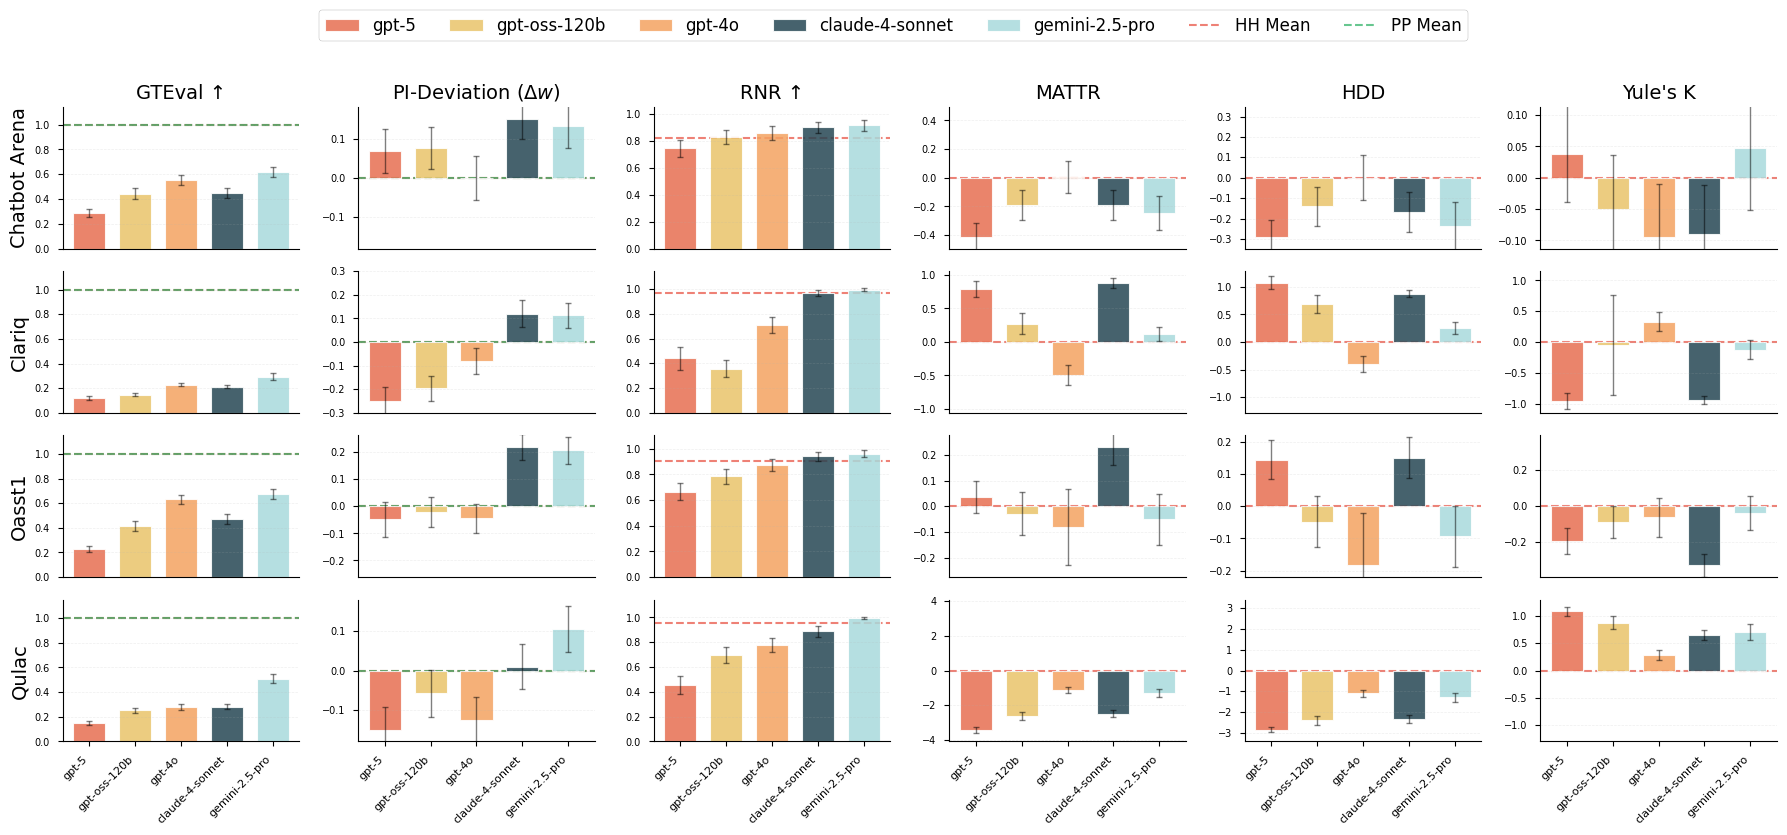


✓ Comprehensive grid created successfully!
Layout: 4 rows (datasets) × 6 columns (metrics)
Features:
  - Non-bold titles for better readability
  - Calibrated mean reference lines (gray for judge metrics, red for z-scores)
  - Consistent color coding across all subplots
  - Error bars showing confidence intervals


In [30]:
# Create the comprehensive dataset × metric grid
print("Creating comprehensive dataset × metric grid...")
print(f"Grid size: {len(DATASETS_FOR_GRID)} datasets × {len(ALL_PAPER_METRICS)} metrics")

fig_comprehensive_grid = plot_dataset_metric_grid(
    df_all,
    datasets=DATASETS_FOR_GRID,
    metrics_list=ALL_PAPER_METRICS,
    metric_labels=METRIC_LABELS,
    dataset_to_results=dataset_to_results,
    figsize=(18, 2.0 * len(DATASETS_FOR_GRID)),  # Scale height with number of datasets
    model_order=GLOBAL_MODEL_ORDER,
    model_colors=MODEL_COLORS_EXTENDED,
    show_ci=True
)
plt.show()

print(f"\n✓ Comprehensive grid created successfully!")
print(f"Layout: {len(DATASETS_FOR_GRID)} rows (datasets) × {len(ALL_PAPER_METRICS)} columns (metrics)")
print(f"Features:")
print(f"  - Non-bold titles for better readability")
print(f"  - Calibrated mean reference lines (gray for judge metrics, red for z-scores)")
print(f"  - Consistent color coding across all subplots")
print(f"  - Error bars showing confidence intervals")

In [31]:
# Save the comprehensive grid figure
print("Saving comprehensive grid figure...")
save_figure(fig_comprehensive_grid, "user_proxy_comprehensive_dataset_metric_grid")

print(f"\n✓ Comprehensive grid saved to: {os.path.abspath(output_dir)}")
print(f"\nComprehensive figure:")
print(f"  {output_dir}/user_proxy_comprehensive_dataset_metric_grid.pdf")
print(f"  {output_dir}/user_proxy_comprehensive_dataset_metric_grid.png")
print(f"\nThis single figure shows:")
print(f"  - All {len(DATASETS_FOR_GRID)} datasets (rows)")
print(f"  - All {len(ALL_PAPER_METRICS)} metrics (columns)")
print(f"  - Calibrated mean reference lines")
print(f"  - Legible non-bold titles")

Saving comprehensive grid figure...
✓ Saved: figures/user_proxy_comprehensive_dataset_metric_grid.pdf and .png

✓ Comprehensive grid saved to: /mnt/shared-fs-1/ashutosh/mirrorbench/figures

Comprehensive figure:
  figures/user_proxy_comprehensive_dataset_metric_grid.pdf
  figures/user_proxy_comprehensive_dataset_metric_grid.png

This single figure shows:
  - All 4 datasets (rows)
  - All 6 metrics (columns)
  - Calibrated mean reference lines
  - Legible non-bold titles
